## Foreword

In this fourth and final assignment, I'll use the discrete variable representation (DVR) method to calculate the energy levels for multiple 1D quantum systems. Specifically, Sine DVR will be employed, which uses the particle-in-a-box (PIAB) eigenfunctions as a basis. I shall compare my calculated energies to known results for the PIAB, harmonic oscillator, and Morse oscillator problems to demonstrate that my code works as expected. Most equations and theory related to DVR in this notebook are made with reference to the appendix of [The multiconfiguration time-dependent Hartree (MCTDH) method: a highly efficient algorithm for propagating wavepackets](https://www.sciencedirect.com/science/article/abs/pii/S0370157399000472) by Beck *et. al.*

First, I'll import required packages/modules and create some variables that will be used throughout my calculations.

In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt

Here, I'll define some global variables for use throughout my calculations. For simplicity's sake, I will set the mass (or reduced mass) of each system I am dealing with to 1. 

In [2]:
x_0 = -5 # starting grid point
L = 10 # length of grid
pi = np.pi
h_bar = 1
mass = 1

The function below calculates the Kronecker delta, $\delta_{jk}$, which will be used to create some matrices later.

In [3]:
def kronecker_delta(j, k):
    if j == k:
        return 1
    return 0

I have elected to use 100 basis functions for my calculations.

In [4]:
# number of basis functions
N = 100

## Create DVR Grid

The first matrix I will create is the position operator matrix, $Q$, which I have done according to B.59.

In [5]:
Q = np.zeros((N, N))

for j in range(1, N + 1):
    for k in range(1, N + 1):
        delta_1 = kronecker_delta(j, k + 1)
        delta_2 = kronecker_delta(j, k - 1)
        Q[j - 1][k - 1] = (delta_1 + delta_2) / 2

The next step is to diagonalize $Q$. I can choose to do this in one of two ways that give me essentially equivalent results. The first way, which is done in the next code cell, is to use NumPy's `linalg.eig` function to calculate the eigenvalues ($z$) and matrix of eigenvectors ($U$) of $Q$.

In [6]:
# diagonalize position operator matrix to get U and z
z, U = np.linalg.eig(Q)

Alternatively, Beck *et. al.* provide analytic methods for obtaining $z$ (B.61) and $U$ (B.60), which I have implemented below for demonstrative purposes. One can validate that `z` = `z_analytic` and `U` = `U_analytic`, but I will choose to use NumPy diagonalization from here on out.

In [7]:
# this code block is just for demonstration purposes
# these are the analytic ways of diagonalizing Q (eqs. B.60 and B.61)
U_analytic = np.zeros((N, N))

for j in range(1, N + 1):
    for a in range(1, N + 1):
        U_analytic[j - 1][a - 1] = (2 / (N + 1)) ** 0.5 * np.sin(j * a * pi / (N + 1))
        
z_analytic = np.cos(np.arange(1, N + 1) * pi / (N + 1))

Now, I can create my DVR grid using B.62. I can do this by explicitly using $z$ (i.e., with the form of $x_{\alpha}$ involving $arccos(z_{\alpha})$) or by using $\Delta x=\frac{L}{N + 1}$, where $L$ is the length of the grid and $N$ is the number of basis functions. The latter method is achieved by recognizing that $z$ is related to $x$ via B.58. In the code cell below, I'll use the "$\Delta x$" method, but I verify that this yields the same grid as the "$z$" method. In either case, my grid falls in the range of (-5, 5), because I chose $x_{0}=-5$ and $L=10$.

In [8]:
# create grid
# note that you'll have as many grid points as basis functions
alphas = np.arange(1, z.shape[0] + 1)
delta_x = L / (N + 1)
grid = x_0 + alphas * delta_x

# verify that creating grid with delta_x and z give the same result
if np.allclose(grid, sorted(x_0 + L / pi * np.arccos(z))):
    print("Grid Created Using delta_x")
    print("--------------------------")
    print()
    print(list(grid))
    print()
    print("Grid Created Using z")
    print("--------------------")
    print()
    print(sorted(x_0 + L / pi * np.arccos(z)))
    print()
    print("Both methods of calculating the grid are equivalent!")

Grid Created Using delta_x
--------------------------

[-4.900990099009901, -4.801980198019802, -4.702970297029703, -4.603960396039604, -4.5049504950495045, -4.405940594059405, -4.306930693069307, -4.207920792079208, -4.108910891089109, -4.00990099009901, -3.910891089108911, -3.8118811881188117, -3.7128712871287126, -3.6138613861386135, -3.514851485148515, -3.4158415841584158, -3.3168316831683167, -3.217821782178218, -3.118811881188119, -3.01980198019802, -2.9207920792079207, -2.8217821782178216, -2.7227722772277225, -2.6237623762376234, -2.5247524752475248, -2.4257425742574257, -2.3267326732673266, -2.2277227722772275, -2.1287128712871284, -2.0297029702970297, -1.9306930693069306, -1.8316831683168315, -1.7326732673267324, -1.6336633663366333, -1.5346534653465347, -1.4356435643564356, -1.3366336633663365, -1.2376237623762374, -1.1386138613861383, -1.0396039603960396, -0.9405940594059405, -0.8415841584158414, -0.7425742574257423, -0.6435643564356432, -0.5445544554455441, -0.445544554455

## Calculate Kinetic Energy Matrix, $T$

Beck *et. al.* provide two ways of calculating the second derivative matrix in Sine DVR. Equation B.57 gives us the finite basis representation (FBR) of the second derivative matrix, $D^{FBR}$, which I will implement in the next code cell.

In [9]:
D2_FBR = np.zeros((N, N))
            
for j in range(1, N + 1):
    for k in range(1, N + 1):
        if j == k:
            D2_FBR[j - 1][k - 1] = -kronecker_delta(j, k) * ((j * pi) / L) ** 2
        else:
            D2_FBR[j - 1][k - 1] = 0

However, B.65 is also provided, which gives us a way to calculate the second derivative matrix in the discrete variable representation, $D^{DVR}$. I calculate this matrix below (fixing the signage error in the textbook on the 1/3 term):

In [10]:
D2_DVR = np.zeros((N, N))

for a in alphas:
    for b in alphas:
        if a == b:
            D2_DVR[a - 1][b - 1] = -(pi / delta_x) ** 2 * ((1 / 3) + (1 / (6 * (N + 1) ** 2)) - (1 / (2 * (N + 1) ** 2 * np.sin((a * pi) / (N + 1)) ** 2)))
        else:
            D2_DVR[a - 1][b - 1] = -(pi / delta_x) ** 2 * (((2 * (-1) ** abs(a - b)) / (N + 1) ** 2) * ((np.sin(a * pi / (N + 1)) * np.sin(b * pi / (N + 1))) / (np.cos(a * pi / (N + 1)) - np.cos(b * pi / (N + 1))) ** 2))

Now that I have the second derivative matrix (in both finite basis representation and DVR representations), I can calculate the kinetic energy matrix. I would also like to show that:

- Calculating $T^{FBR}$ from $D^{FBR}$ is very simple: all I have to do is multiply the matrix elements of $D^{FBR}$ by $\frac{-\hbar^{2}}{2m}$

- Calculating $T^{FBR}$ from $D^{DVR}$ is a bit more involved: first, you can obtain $T^{DVR}$ by multiplying $D^{DVR}$ by $\frac{-\hbar^{2}}{2m}$ as above; then, you can get $T^{FBR}$ by diagonalizing $T^{DVR}$ ($T^{FBR}$ is the diagonal matrix of eigenvalues of $T^{DVR}$ - see B.18)

In the code cell below, I'll show that both methods of calculating $T^{FBR}$ give the same result.

In [11]:
# calculate kinetic energy matrix in FBR
T_FBR = - (h_bar ** 2) / (2 * mass) * D2_FBR

# calculate kinetic energy matrix in DVR
T_DVR = - (h_bar ** 2) / (2 * mass) * D2_DVR

# diagonalize T_DVR and show that eigenvalue matrix is T_FBR
# eigenvalues of T_DVR are sorted(E_T_DVR)
# diagonal elements of T_FBR are list(np.diag(T_FBR))
# use np.allclose to assert that these two lists of numbers are same
E_T_DVR, _ = np.linalg.eig(T_DVR)
print("T_FBR corresponds to eigenvalues of T_DVR?", np.allclose(sorted(E_T_DVR), list(np.diag(T_FBR))))

T_FBR corresponds to eigenvalues of T_DVR? True


## PIAB

As we know, the PIAB Hamiltonian is very simple, just consisting of a kinetic energy term: $H=\frac{-\hbar}{2m}\frac{d^{2}}{dx^{2}}\psi(x)$

This means that the Hamiltonian matrix for this problem is just the kinetic energy matrix, which we have calculated above. Below, I demonstrate that diagonalizing $T^{DVR}$ to get its eigenvalues yields the energy levels for a PIAB, $E_{n}=\frac{n^{2}\hbar^{2}\pi^{2}}{2mL^2}$

In [12]:
# calculate PIAB energy levels analytically
analytical_energy_levels = np.arange(1, N + 1) ** 2 * pi ** 2 * h_bar ** 2 / (2 * mass * L ** 2)

if np.allclose(analytical_energy_levels, sorted(E_T_DVR)):
    print("Analytical Energy Levels (n = 1 to n = 100)")
    print("-------------------------------------------")
    print()
    print(analytical_energy_levels)
    print()
    print("Eigenvalues of T_DVR")
    print("--------------------")
    print()
    print(sorted(E_T_DVR))
    print()
    print("Diagonalizing T_DVR yields the PIAB energy levels!")

Analytical Energy Levels (n = 1 to n = 100)
-------------------------------------------

[  0.04934802   0.19739209   0.4441322    0.78956835   1.23370055
   1.77652879   2.41805308   3.15827341   3.99718978   4.9348022
   5.97111066   7.10611517   8.33981572   9.67221231  11.10330495
  12.63309363  14.26157836  15.98875913  17.81463594  19.7392088
  21.7624777   23.88444265  26.10510364  28.42446068  30.84251375
  33.35926288  35.97470804  38.68884925  41.50168651  44.4132198
  47.42344915  50.53237453  53.73999596  57.04631344  60.45132696
  63.95503652  67.55744213  71.25854378  75.05834147  78.95683521
  82.95402499  87.04991082  91.24449269  95.5377706   99.92974456
 104.42041456 109.00978061 113.6978427  118.48460084 123.37005501
 128.35420524 133.4370515  138.61859381 143.89883217 149.27776657
 154.75539701 160.3317235  166.00674603 171.7804646  177.65287922
 183.62398988 189.69379659 195.86229934 202.12949813 208.49539297
 214.95998386 221.52327078 228.18525375 234.94593277 241

## Harmonic Oscillator

The harmonic oscillator Hamiltonian is $H=\frac{-\hbar^2}{2m}\frac{d^2}{dx^2}\psi(x) + \frac{1}{2}kx^2\psi(x)$

Now, we are dealing with a potential energy term in addition to a kinetic energy term, which is where DVR really shines. This will necessitate that we calculate $V^{DVR}$, which can be done as per B.20. Then, I can obtain my Hamiltonian matrix using $V^{DVR}$ and $T^{DVR}$ from before, from which I can get my energy levels. First, though, I need to define a harmonic oscillator potential (note that, for simplicity, I will assume the force constant, $k$, is equal to 1):

In [13]:
def harmonic_oscillator_potential(k, x):
    return 0.5 * k * x ** 2

V_harmonic = harmonic_oscillator_potential(1, grid)

We can plot our harmonic oscillator potential along our grid:

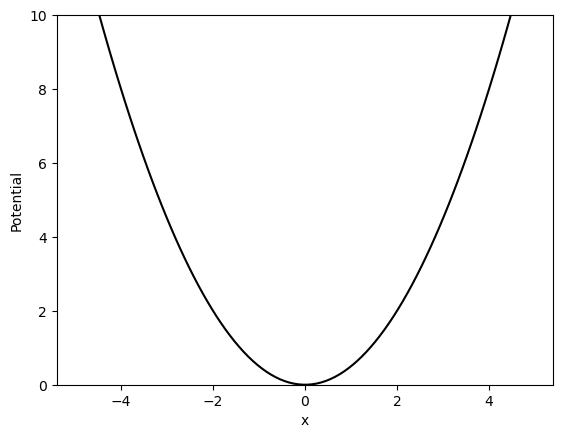

In [14]:
plt.xlabel("x")
plt.ylabel("Potential")
plt.ylim(0, 10)
plt.plot(grid, V_harmonic, 'black')

Below is my implementation of B.20:

In [15]:
# implement B.20
V_DVR_harmonic = np.zeros((N, N))

for a in range(1, N + 1):
    for b in range(1, N + 1):
        V_DVR_harmonic[a - 1][b - 1] = V_harmonic[a - 1] * kronecker_delta(a, b)

 Here, I'll calculate my Hamiltonian matrix and diagonalize it to obtain its eigenvalues:

In [16]:
H_harmonic = T_DVR + V_DVR_harmonic

E_harmonic, _ = np.linalg.eig(H_harmonic)

The analytical expression for the harmonic oscillator energy levels is $E_n = (n + \frac{1}{2})\hbar \omega=(n + \frac{1}{2})\hbar\sqrt{\frac{k}{m}}$. Recall that I've set $k$ and $m$ to 1, so $\omega$ is also equal to 1. Thus, the energy levels for our harmonic oscillator example should be $E_n = (n + \frac{1}{2})$. I will demonstrate that my code works properly by overlaying my first 10 calculated energy levels on the potential of my system. As you can see, this generates a familiar picture of the harmonic oscillator energy levels:

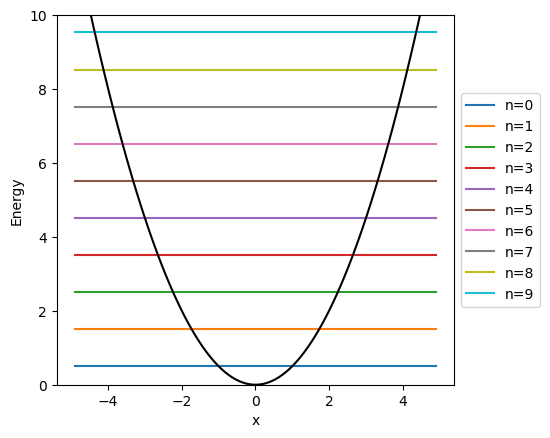

In [17]:
fig = plt.figure()
ax = plt.subplot(111)

for i in range(10):
    ax.plot(grid, np.full(N, sorted(E_harmonic)[i]), label=f"n={i}")

ax.plot(grid, V_harmonic, 'black')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylim(0, 10)
ax.set_xlabel('x')
ax.set_ylabel('Energy')

plt.show()

## Morse Oscillator

Now, let's work with a Morse oscillator. First, I'll redefine my grid, because it is unphysical to look at regions where $x$ < 0 with this type of potential.

In [18]:
x_0 = 0 # starting grid point
L = 20 # length of grid

alphas = np.arange(1, z.shape[0] + 1)
delta_x = L / (N + 1)
grid = x_0 + alphas * delta_x

In [19]:
De = 20
alpha = 1
re = 7.1053

def morse_potential(r):
    return De * (np.exp(-2 * alpha * (r - re)) - 2 * np.exp(-alpha * (r - re)))

V_morse = morse_potential(grid)

Here's what our Morse potential looks like:

(5.5, 20.0)

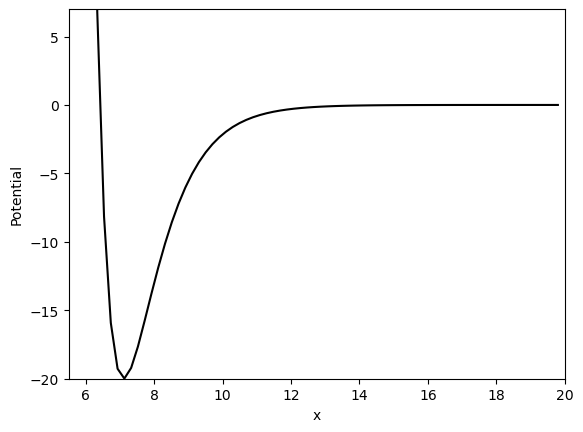

In [20]:
plt.plot(grid, V_morse, 'black')
plt.ylabel('Potential')
plt.xlabel('x')
plt.ylim(-20, 7)
plt.xlim(5.5, 20)

Now, I'll go through the familiar process of calculating my Hamiltonian matrix in the DVR representation and diagonalizing it to get my energy levels.

In [21]:
# implement B.20
V_DVR_morse = np.zeros((N, N))

for a in range(1, N + 1):
    for b in range(1, N + 1):
        V_DVR_morse[a - 1][b - 1] = V_morse[a - 1] * kronecker_delta(a, b)

I have recalculated my $T^{DVR}$ for this problem in accordance with [what is reported by Colbert and Miller (section A.2)](https://www.cchem.berkeley.edu/~millergrp/pdf/243.pdf). I have chosen to do this because it appears to give me more intuitive energy levels compared to when I used B.65 from Beck *et. al.*

In [22]:
T_DVR_morse = np.zeros((N, N))

for a in range(1, N + 1):
    for b in range(1, N + 1):
        if a == b:
            T_DVR_morse[a - 1][b - 1] = (h_bar ** 2 / (2 * mass * (L / N) ** 2)) * (-1) ** abs(a - b) * (pi ** 2 / 3 - 1 / (2 * a ** 2))
        else:
            T_DVR_morse[a - 1][b - 1] = (h_bar ** 2 / (2 * mass * (L / N) ** 2)) * (-1) ** abs(a - b) * ((2 / (a - b) ** 2) - (2 / (a + b) ** 2))

In [23]:
H_morse = T_DVR_morse + V_DVR_morse

E_morse, _ = np.linalg.eig(H_morse)

Finally, I'll overlay a subset of my calculated Morse oscillator energy levels on the Morse potential being dealt with. From this plot, you can see a decrease in $\Delta E$ between energy levels as we approach the dissociation limit of the curve. This is typical of bound states of the Morse oscillator.

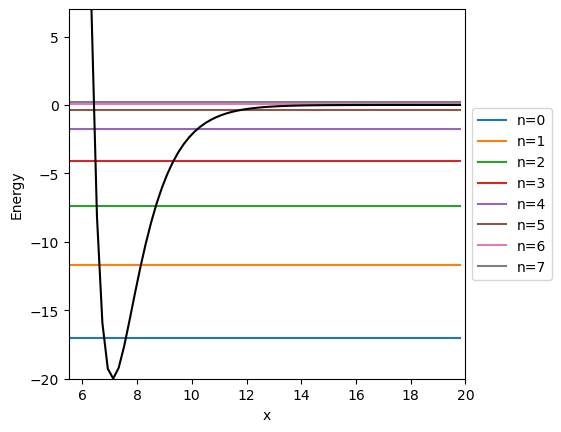

In [24]:
fig = plt.figure()
ax = plt.subplot(111)

for i in range(8):
    ax.plot(grid, np.full(N, sorted(E_morse)[i]), label=f"n={i}")

ax.plot(grid, V_morse, 'black')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlim(5.5, 20)
ax.set_ylim(-20, 7)
ax.set_xlabel('x')
ax.set_ylabel('Energy')

plt.show()

As a brief aside, this is the plot that I would've gotten if I used B.65 to calculate $T^{DVR}$ rather than (A8) from Colbert and Miller. When plotting the same subset of Morse energy levels, I still get the decrease in $\Delta E$ as $E$ approaches the dissociation limit, but it appears that some of these states are now very much unbound. 

In [25]:
H_morse = T_DVR + V_DVR_morse

E_morse, _ = np.linalg.eig(H_morse)

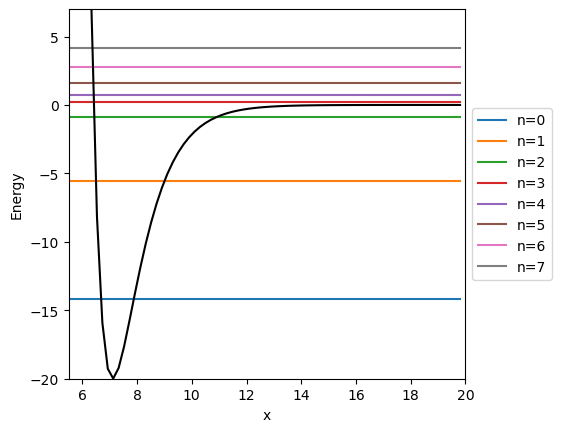

In [26]:
fig = plt.figure()
ax = plt.subplot(111)

for i in range(8):
    ax.plot(grid, np.full(N, sorted(E_morse)[i]), label=f"n={i}")

ax.plot(grid, V_morse, 'black')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlim(5.5, 20)
ax.set_ylim(-20, 7)
ax.set_xlabel('x')
ax.set_ylabel('Energy')

plt.show()